<a href="https://colab.research.google.com/github/Maya-Poghosyan/Parkinsons-Diagnosis/blob/main/Parkinson's_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Parkinson's Diagnosis


---
$Project$ $Goal$: Algorithm that can predict impact of Parkinson's disease on motor and speech functions. <br>
Dataset info can be found on Github <a href = "https://github.com/imadtoubal/Parkinson-s-Disease-Classification-from-Speech-Data">here</a>.<br>
Note: `class` is a binary identifier of Parkinson's (1 - diseased, 0 - healthy control)

In [1]:
# import Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# import libraries (there's a lot)
import pandas as pd
import sklearn
import seaborn as sns
import scipy
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import torch

Mounted at /content/gdrive


In [2]:
df = pd.read_csv('/content/gdrive/My Drive/Programming/ACSEF 2021/pd_speech_features.csv')
df.dropna(axis=0,inplace=True)
df.groupby('class').mean()
labels = df['class']
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.0295,2.0362,1.8478,2.5776,2.2064,1.9491,1.9120,1.8829,6.9761,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.3

Here is a simple function that can test metrics of our models as we go along -- it checks for accuracy, precision, and recall.

In [3]:
# model stats calculator (can this work with CNNS?) 
def model_stats(y_test,y_pred):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  precision = metrics.precision_score(y_test, y_pred)
  recall = metrics.recall_score(y_test, y_pred)
  print(accuracy)
  print(precision)
  print(recall)

# Principal Component Analysis

**Principal Component Analysis** - "scales down" data and dimensions to find most important correlations and relationships between the data. More information can be found <a href = "https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python">here</a>. Standard imports are as follows: <br>
`from sklearn.decomposition import PCA`<br>
`from sklearn.preprocessing import StandardScaler`

In [4]:
df2 = df.drop(columns='class',axis=1)

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(df2)
feature_scaled = scaler1.transform(df2)
pc1 = PCA(n_components=4)
pc1.fit(feature_scaled)
feature_scaled_pca = pc1.transform(feature_scaled)
print(np.shape(feature_scaled_pca))

(756, 4)


In [6]:
pcomponent1 = feature_scaled_pca[:, 0]
pcomponent2 = feature_scaled_pca[:, 1]
pcomponent3 = feature_scaled_pca[:, 2]
pcomponent4 = feature_scaled_pca[:, 3]
feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))
print("Variance Ratio of the 4 Principal Components Analysis: ", feat_var_rat)
print("Our four principal components account for almost 90% of variance in the dataset.")

Variance Ratio of the 4 Principal Components Analysis:  [0.42260888 0.28561276 0.1596861  0.13209226]
Our four principal components account for almost 90% of variance in the dataset.


In [7]:
df = pd.DataFrame(feature_scaled_pca, columns = ['principal component 1', 'principal component 2',
                                                 'principal component 3', 'principal component 4'])
df['label'] = labels
df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,label
0,-1.345768,-0.561464,-1.012609,-0.137229,1
1,-1.457105,-0.497098,-1.117513,0.188325,1
2,-1.929426,-0.180870,-0.951920,0.269965,1
3,-0.386014,-1.766024,1.813981,-0.398953,1
4,-0.161909,-1.189702,1.912959,-0.745900,1


In [8]:
odata = pd.read_csv('/content/gdrive/My Drive/Programming/ACSEF 2021/pd_speech_features.csv')
odata.shape

(756, 755)

In [9]:
''' This loop gives us the top feature of each component using the argmax function '''
top_features = [np.abs(pc1.components_[i]).argmax() for i in range(pc1.components_.shape[0])]


''' Now, we go back to our original feature names (columns of our dataset), and get the names of the 4 key features '''
top_feature_names = [list(odata.columns)[top_features[i]] for i in range(pc1.components_.shape[0])]

''' printing the names '''
for n,name in enumerate(top_feature_names):
	print("#" + str(n) + ": " + str(name))

#0: tqwt_entropy_shannon_dec_16
#1: gender
#2: det_entropy_log_7_coef
#3: gender


In [10]:
# SHAPIRO - should be lower than 0.005
f, p = scipy.stats.f_oneway(df['principal component 1'][df['label'] == 0],
               df['principal component 1'][df['label'] == 1])
print(f'Our p-value is {p}.')
print("This indicates real correlation in the data.")

Our p-value is 2.4100254916016902e-36.
This indicates real correlation in the data.


# Simpler Methods

**Logistic Regression** - predicting whether a patient will be 0 (Healthy), or 1 (Parkinson's). More info can be found <a href = "https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python">here</a>. Input labels are the principal components.

In [90]:
train_df, test_df = train_test_split(df, test_size = 0.4, random_state = 1)
train_df.head()
input_labels = ['principal component 1','principal component 2','principal component 3', 'principal component 4']
output_label = 'label'

x_train = train_df[input_labels]
y_train = train_df[output_label]
class_rm = linear_model.LogisticRegression()
class_rm.fit(x_train,y_train)
x_test = test_df[input_labels]
y_test = test_df[output_label].values.squeeze() # what does squeeze mean
y_pred = class_rm.predict(x_test)
y_pred = y_pred.squeeze()
x_test_view = x_test[input_labels].values.squeeze()
y_prob = class_rm.predict_proba(x_test)
model_stats(y_test,y_pred)

0.7887788778877888
0.8617886178861789
0.8760330578512396


Let's test a single Support Vector Machine (SVM).

In [91]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train,y_train)
clfp = clf.predict(x_test)
model_stats(y_test, clfp)

0.8151815181518152
0.8549618320610687
0.9256198347107438


We can also test a pre-built multilayer perceptron convolutional neural network model.

In [17]:
nnet = MLPClassifier(hidden_layer_sizes=(10), max_iter= 1000)  
nnet.fit(x_train, y_train)
predictions = nnet.predict(x_test)
print("MLP Testing Set Score:")
print(accuracy_score(y_test, predictions)*100)

MLP Testing Set Score:
82.17821782178217


# Bagging Method

**B**ootstrap **Agg**regat**ing**, or "bagging", is an ensemble method that combines the results of many decision trees and support vector machines. <br> We will also be using the KFolding method, which splits and shuffles our data to prevent overfitting.

In [52]:
from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)
# enumerate splits
for train, test in kfold.split(df):
	print('train: %s, test: %s' % (train_df, test_df))

train:      principal component 1  principal component 2  ...  principal component 4  label
361               0.180217               1.755048  ...              -0.844578      1
262               0.317124              -1.887943  ...              -0.270243      1
92               -1.398340               1.868493  ...              -0.334578      1
479              -2.564691               1.981823  ...               0.145573      1
496               0.767590              -0.787185  ...               0.010289      1
..                     ...                    ...  ...                    ...    ...
645              -0.330780              -2.372383  ...              -0.636352      1
715              -0.027997               0.931396  ...              -1.234619      1
72                1.000634              -1.218521  ...              -0.112985      0
235              -1.563920               0.134973  ...               0.113586      0
37                0.347815              -2.006603  ...    

In [83]:
# bagging classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0)

acc_score = []
for train_index , test_index in kfold.split(df):
    X_train , X_test = df.iloc[train_index,:],df.iloc[test_index,:]
    Y_train , Y_test = labels[train_index] , labels[test_index]
    bagging.fit(X_train,Y_train)
    pred_values = bagging.predict(X_test)
     
    acc = accuracy_score(pred_values , Y_test)
    acc_score.append(acc)

print("Our accuracy scores:\n",acc_score)

Our accuracy scores:
 [1.0, 1.0, 0.9880952380952381]


Text(0.5, 257.44, 'Predicted diagnosis')

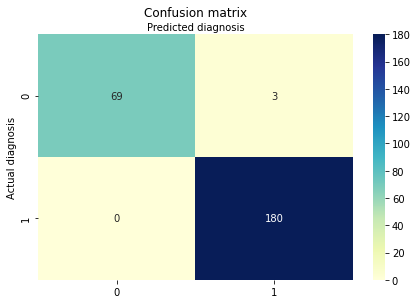

In [73]:
# Confusion Matrix
import matplotlib.pyplot as plt
cnf_matrix = metrics.confusion_matrix(y_test, pred_values)

# Visualizing the Confusion Matrix
class_names = [0,1] # Our diagnosis categories

fig, ax = plt.subplots()
# Setting up and visualizing the plot 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') # Creating heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y = 1.1)
plt.ylabel('Actual diagnosis')
plt.xlabel('Predicted diagnosis')

This ensemble method has outperformed any other single method, even achieving perfect accuracy. 